# 전라남도 개별/공동주택 + 인구데이터 전처리

### 사용 라이브러리

In [1]:
# 필요한 라이브러리 로드
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
import seaborn as sns

### 사용 함수

In [ ]:
# 주소를 정리하는 함수 정의
def preprocess_address(df):
    ''''''
    
    # "지번" 컬럼에서 -를 기준으로 분리
    df['지번본번'] = df['지번'].str.split('-').str[0]
    
    # 법정동명과 지번을 합친 "주소" 컬럼을 만들어 반환
    df['주소'] = df['법정동명'] + ' ' + df['지번']
    
    # 지번별 총 연면적을 계산
    try:
        df['지번별 연면적'] = df.groupby(['주소'])['전용면적'].transform('sum')
        df = df.drop('전용면적', axis=1)
    except:
        df['지번별 연면적'] = df.groupby(['주소'])['건물산정연면적'].transform('sum')
        df = df.drop('건물산정연면적', axis=1)
    
    df = df.drop_duplicates(['주소'])
    
    return df

## 개별/공동주택 데이터
주택데이터에서 지번별 사용 면적을 추출하여 

In [2]:
# 전남 주택가격정보 데이터 불러오기
raw_jeonnam_shared = pd.read_csv('./data/전남_공동주택가격정보.csv', encoding='cp949', low_memory=False)
raw_jeonnam_private = pd.read_csv('./data/전남_개별주택가격정보.csv', encoding='cp949', low_memory=False)

In [3]:
raw_jeonnam_private['데이터기준일자'].describe()

count         394033
unique             1
top       2024-01-20
freq          394033
Name: 데이터기준일자, dtype: object

날짜 기준은 2024년 1월 기준임을 확인

In [4]:
# 필요한 컬럼만 추출
df_jeonnam_shared = raw_jeonnam_shared[['고유번호', '법정동코드', '법정동명', '지번', '특수지구분코드', '특수지구분명', '전용면적']]
df_jeonnam_private = raw_jeonnam_private[['고유번호', '법정동코드', '법정동명', '지번', '특수지구분코드', '특수지구분명', '건물산정연면적']]

In [5]:
# NaN값을 가진 행 제거
df_jeonnam_shared = df_jeonnam_shared.dropna()
df_jeonnam_private = df_jeonnam_private.dropna()

<Axes: ylabel='Frequency'>

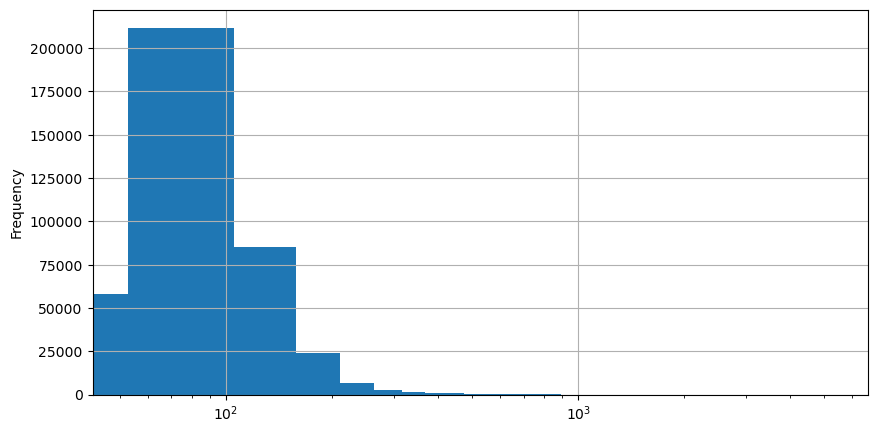

In [6]:
# 전남 개별주택 토지대장면적 분포 시각화
# x축은 log scale로 표현
df_jeonnam_private['건물산정연면적'].plot(kind='hist', bins=100, grid=True, figsize=(10, 5), logx=True)

In [7]:
# 주소를 정리하는 함수 정의
def preprocess_address(df):
    
    # "지번" 컬럼에서 -를 기준으로 분리
    df['지번본번'] = df['지번'].str.split('-').str[0]
    
    # 법정동명과 지번을 합친 "주소" 컬럼을 만들어 반환
    df['주소'] = df['법정동명'] + ' ' + df['지번']
    
    # 지번별 총 연면적을 계산
    try:
        df['지번별 연면적'] = df.groupby(['주소'])['전용면적'].transform('sum')
        df = df.drop('전용면적', axis=1)
    except:
        df['지번별 연면적'] = df.groupby(['주소'])['건물산정연면적'].transform('sum')
        df = df.drop('건물산정연면적', axis=1)
    
    df = df.drop_duplicates(['주소'])
    
    return df

In [8]:
# 데이터 프레임 정리
df_private = preprocess_address(df_jeonnam_private)
df_shared = preprocess_address(df_jeonnam_shared)

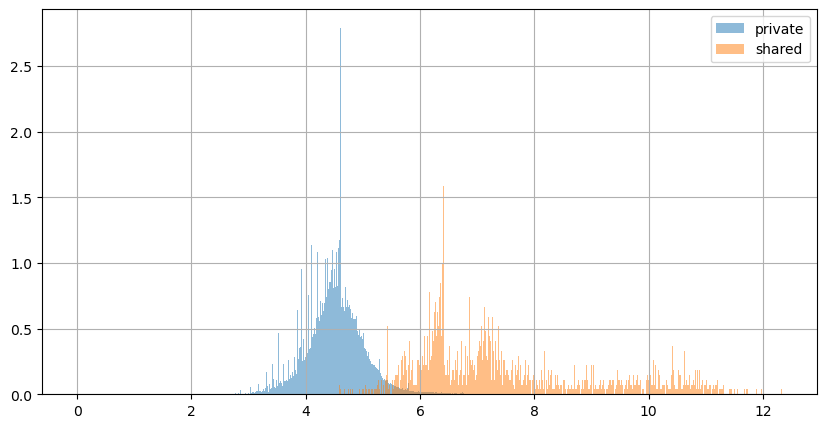

In [9]:
# 지번본번별 연면적 시각화, PDF 그래프로 확인
plt.figure(figsize=(10, 5))
plt.hist(df_private['지번별 연면적'].apply(lambda x: np.log(x+1)), bins=1000, density=True, alpha=0.5, label='private')
plt.hist(df_shared['지번별 연면적'].apply(lambda x: np.log(x+1)), bins=1000, density=True, alpha=0.5, label='shared')
plt.grid(True)
plt.legend()
plt.show()

In [10]:
# 전남 개별주택과 공동주택 데이터를 concat으로 합침
df = pd.concat([df_private, df_shared])

In [11]:
# 주소가 중복되는 데이터 확인
df.loc[df['주소'].duplicated(keep=False)].sort_values('주소')

,고유번호,법정동코드,법정동명,지번,특수지구분코드,특수지구분명,지번본번,주소,지번별 연면적
239477,4681025023100580001,4681025023,전라남도 강진군 강진읍 서성리,58-1,1,일반,58,전라남도 강진군 강진읍 서성리 58-1,75.62
357610,4681025023100580001,4681025023,전라남도 강진군 강진읍 서성리,58-1,1,일반,58,전라남도 강진군 강진읍 서성리 58-1,5486.40
332078,4677025026106590003,4677025026,전라남도 고흥군 고흥읍 남계리,659-3,1,일반,659,전라남도 고흥군 고흥읍 남계리 659-3,714.16
165368,4677025026106590003,4677025026,전라남도 고흥군 고흥읍 남계리,659-3,1,일반,659,전라남도 고흥군 고흥읍 남계리 659-3,47.30
165447,4677025026107130001,4677025026,전라남도 고흥군 고흥읍 남계리,713-1,1,일반,713,전라남도 고흥군 고흥읍 남계리 713-1,1740.64
...,...,...,...,...,...,...,...,...,...
353855,4680025037104770002,4680025037,전라남도 장흥군 장흥읍 건산리,477-2,1,일반,477,전라남도 장흥군 장흥읍 건산리 477-2,1246.26
366688,4690025021107120000,4690025021,전라남도 진도군 진도읍 동외리,712,1,일반,712,전라남도 진도군 진도읍 동외리 712,86.94
414113,4690025021107120000,4690025021,전라남도 진도군 진도읍 동외리,712,1,일반,712,전라남도 진도군 진도읍 동외리 712,2757.24
253098,4682025021103050002,4682025021,전라남도 해남군 해남읍 해리,305-2,1,일반,305,전라남도 해남군 해남읍 해리 305-2,69.60


In [12]:
# 주소가 중복되는 데이터 중에서 연면적의 sum을 계산
df['지번별 연면적 합'] = df.groupby('주소')['지번별 연면적'].transform('sum')

# 중복되는 주소의 데이터 중에서 연면적이 작은 데이터를 제거
df = df.drop_duplicates('주소', keep='first')
df = df.drop('지번별 연면적', axis=1)

한국 전체 기준 1인당 평균 주거 면적이 2020년 기준 33.9 $m^2$ 이다

In [13]:
# 지번별 연면적을 1인당 평균 주거면적으로 나눔
df['지번별 추정 인구수'] = (df['지번별 연면적 합'] / 33.9)
df[['지번별 연면적 합','지번별 추정 인구수']].describe()

,지번별 연면적 합,지번별 추정 인구수
count,388839.000000,388839.000000
mean,176.000262,5.191748
std,1880.314485,55.466504
min,0.000000,0.000000
25%,66.000000,1.946903
50%,89.340000,2.635398
75%,119.260000,3.517994
max,226185.570000,6672.140708


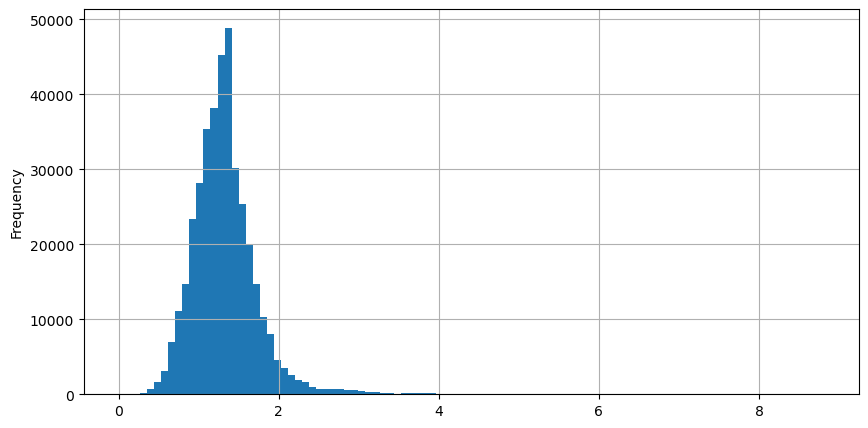

In [14]:
# 주소별 추정 인구수 분포를 log를 씌워 시각화
plt.figure(figsize=(10, 5))
df['지번별 추정 인구수'].apply(lambda x: np.log(x+1)).plot(kind='hist', bins=100, grid=True)
plt.show()

---
---

### 총 인구 및 70세 이상 인구 데이터를 가져와서 합침

In [15]:
df_pop_jeonnam = pd.read_csv('./data/jeonnam_pop.csv', encoding='cp949')

# 컬럼명 변경
df_pop_jeonnam.columns

Index(['법정동코드', '시도명', '시군구명', '읍면동명', '리명', '읍면동리 총 인구수', '읍면동리 70세이상 인구수',
       '읍면동리 70세이상 인구비율', '읍면동 총 인구수', '읍면동 총 70세이상 인구수', '읍면동 70세이상 인구비율'],
      dtype='object')

In [16]:
df_pop_jeonnam.head()

,법정동코드,시도명,시군구명,읍면동명,리명,읍면동리 총 인구수,읍면동리 70세이상 인구수,읍면동리 70세이상 인구비율,읍면동 총 인구수,읍면동 총 70세이상 인구수,읍면동 70세이상 인구비율
0,4611010100,전라남도,목포시,용당동,용당동,12477,3024,24.236595,12477,3024,24.236595
1,4611010200,전라남도,목포시,산정동,산정동,41280,7389,17.899709,41280,7389,17.899709
2,4611010300,전라남도,목포시,연산동,연산동,13039,1129,8.658639,13039,1129,8.658639
3,4611010400,전라남도,목포시,대성동,대성동,3899,525,13.464991,3899,525,13.464991
4,4611010500,전라남도,목포시,양동,양동,1318,365,27.693475,1318,365,27.693475


In [17]:
# 법정동코드를 기준으로 데이터를 병합
df_final = pd.merge(df.drop(['법정동명', '지번본번'], axis=1),
                    df_pop_jeonnam, on='법정동코드', how='left')
df_final.head()

,고유번호,법정동코드,지번,특수지구분코드,특수지구분명,주소,지번별 연면적 합,지번별 추정 인구수,시도명,시군구명,읍면동명,리명,읍면동리 총 인구수,읍면동리 70세이상 인구수,읍면동리 70세이상 인구비율,읍면동 총 인구수,읍면동 총 70세이상 인구수,읍면동 70세이상 인구비율
0,4611010100101710003,4611010100,171-3,1,일반,전라남도 목포시 용당동 171-3,64.84,1.912684,전라남도,목포시,용당동,용당동,12477.0,3024.0,24.236595,12477.0,3024.0,24.236595
1,4611010100101710038,4611010100,171-38,1,일반,전라남도 목포시 용당동 171-38,85.19,2.512979,전라남도,목포시,용당동,용당동,12477.0,3024.0,24.236595,12477.0,3024.0,24.236595
2,4611010100101710039,4611010100,171-39,1,일반,전라남도 목포시 용당동 171-39,119.93,3.537758,전라남도,목포시,용당동,용당동,12477.0,3024.0,24.236595,12477.0,3024.0,24.236595
3,4611010100101710040,4611010100,171-40,1,일반,전라남도 목포시 용당동 171-40,84.69,2.498230,전라남도,목포시,용당동,용당동,12477.0,3024.0,24.236595,12477.0,3024.0,24.236595
4,4611010100101710041,4611010100,171-41,1,일반,전라남도 목포시 용당동 171-41,81.96,2.417699,전라남도,목포시,용당동,용당동,12477.0,3024.0,24.236595,12477.0,3024.0,24.236595


In [18]:
df_final.loc[df_final['읍면동리 총 인구수'].isnull()]

,고유번호,법정동코드,지번,특수지구분코드,특수지구분명,주소,지번별 연면적 합,지번별 추정 인구수,시도명,시군구명,읍면동명,리명,읍면동리 총 인구수,읍면동리 70세이상 인구수,읍면동리 70세이상 인구비율,읍면동 총 인구수,읍면동 총 70세이상 인구수,읍면동 70세이상 인구비율
329331,4688025036107220000,4688025036,722,1,일반,전라남도 장성군 장성읍 용곡리 722,156.80,4.625369,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
336519,4688036032100670001,4688036032,67-1,1,일반,전라남도 장성군 황룡면 관동리 67-1,254.08,7.494985,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


결측치 존재 여부를 확인해 봤더니 두개의 열에 대한 법정동별 인구 데이터가 없었습니다.\
지도상으로 확인했을 때 농경지 옆에 있는 곳들이라 인구가 없을 수도 있다고 생각, 제외하기로 결정했습니다.

In [19]:
# 결측치 열 제거
df_final = df_final.dropna()

In [20]:
# 예측 값이랑 실제 값이랑 비교
df_final['읍면동리별 추정 인구수'] = df_final.groupby(['법정동코드'])['지번별 추정 인구수'].transform('sum')

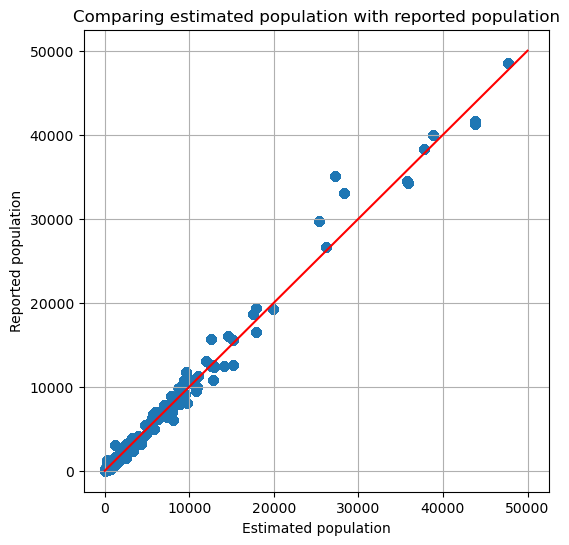

In [21]:
# 법정동 별 추정 인구수와 법정동 총 인구를 시각화하여 비교
plt.figure(figsize=(6, 6))
plt.scatter(df_final['읍면동리별 추정 인구수'], df_final['읍면동리 총 인구수'])

# y=x 그래프 추가
plt.plot([0, 50000], [0, 50000], 'r')

plt.grid(True)
plt.title('Comparing estimated population with reported population')
plt.xlabel('Estimated population')
plt.ylabel('Reported population')
plt.show()

주택 면적으로 통해 예측한 추정 인구수가 실제 법정동 총 인구수와 비슷하게 나타나는 것을 확인할 수 있습니다.

이는 주택 면적을 인구 밀집도의 지표로 쓸 수 있다는 것을 보여줍니다.

이렇게 개별+공동주택 데이터를 가져와 해당 주소별 연면적을 계산하고, 이 정보가 해당 지역의 인구 밀집도랑 상관계수가 높은 수치인 것을 보여주었습니다.

In [22]:
df_final.drop('읍면동리별 추정 인구수', axis=1).to_csv('jeonnam_housing_pop.csv', encoding='cp949', index=False)

In [23]:
df_final.describe()

,법정동코드,특수지구분코드,지번별 연면적 합,지번별 추정 인구수,읍면동리 총 인구수,읍면동리 70세이상 인구수,읍면동리 70세이상 인구비율,읍면동 총 인구수,읍면동 총 70세이상 인구수,읍면동 70세이상 인구비율,읍면동리별 추정 인구수
count,3.888370e+05,388837.000000,388837.000000,388837.000000,388837.000000,388837.000000,388837.000000,388837.000000,388837.000000,388837.000000,388837.000000
mean,4.660198e+09,1.008518,176.000111,5.191744,2898.362520,448.315533,30.119516,7813.648339,1480.379143,28.299795,3075.540090
std,3.159996e+07,0.092177,1880.319316,55.466646,7766.644224,1089.862453,10.305730,10645.057624,1261.766378,9.597160,7980.121229
min,4.611010e+09,1.000000,0.000000,0.000000,3.000000,0.000000,0.000000,4.000000,0.000000,0.000000,1.368732
25%,4.617032e+09,1.000000,66.000000,1.946903,216.000000,76.000000,24.050046,2300.000000,775.000000,21.037806,316.084661
50%,4.678025e+09,1.000000,89.340000,2.635398,370.000000,123.000000,31.531532,3382.000000,1069.000000,30.788006,525.171091
75%,4.684025e+09,1.000000,119.260000,3.517994,1017.000000,266.000000,37.267081,8527.000000,1773.000000,35.543657,1157.435398
max,4.691042e+09,6.000000,226185.570000,6672.140708,48540.000000,7389.000000,66.666667,56142.000000,7389.000000,49.090909,47667.700590


---